# Buscador de imágenes con índice invertido

Genera un buscador de imágenes usando índice inverso y visualiza las imágenes con mayor
similitud de Jaccard, MinMax y Coseno. Para su implementación debes usar Spark.

Cisneros Aguilar Sara Kenia

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sci

from abc import ABC, abstractmethod

from os import listdir
from os.path import isfile, join
from os.path import splitext

## Resumen archivos

### Test - Train.mat
Contienen:
1. header
2. version
3. globals
4. test_info (tiene niveles)
    1. Ruta de las diferentes imagenes con extención
    2. Ruta de las diferentes imagenes sin extención
    3. Número de carpeta de la imagen x
    4. Histograma de información de la imagen x
5. test_fg_data 
6. test_data

### File, Test, Train list.mat

Contienen:
1. header
2. version
3. globals
4. file_list: Ruta de las diferentes imagenes con extención
5. annotation_list: Ruta de las diferentes imagenes sin extención
6. labels

### Annotation
Contiene las carpetas con los respectivos nombres de cada imagen

### List ent y val
Nombre de las imagenes de entrenamiento y validación

### Dogs ent val
Bolsa de caracteristicas de las imagenes de entrenamiento y validación

## Lectura de archivos
Leemos los nombres de las imagenes dividiendo en dos grupos, base y consulta, tomando ent_dogs y val_dogs respectivamente

In [2]:
nomBase = open('lista_ent_dogs.txt','r')
nomCon = open('lista_val_dogs.txt','r')
rut_base = nomBase.read().split()
rut_con = nomCon.read().split()
nomBase.close()
nomCon.close()

Leemos caracteristicas

In [3]:
bolBase = open('dogs_ent.corpus','r')
bolCon = open('dogs_val.corpus','r')
bol_base = bolBase.read().split()
bol_con = bolCon.read().split()
bolBase.close()
bolCon.close()

In [4]:
bolsaBase = []
while bol_base:
    cont = int(bol_base.pop(0))
    l = []
    for i in range(cont):
        f = int(bol_base.pop(0).split(":")[0])
        l.append(f)
    bolsaBase.append(l)

In [5]:
bolsaCon = []
while bol_con:
    cont = int(bol_con.pop(0))
    l = []
    for i in range(cont):
        f = int(bol_con.pop(0).split(":")[0])
        l.append(f)
    bolsaCon.append(l)

## Visualización de imagenes
### Primero obtenemos las rutas de las imagenes que se tomaron de base y consulta, pues solo conocemos su nombre

In [6]:
test = sci.loadmat('test_data.mat')
print(test.keys())

dict_keys(['__header__', '__version__', '__globals__', 'test_info', 'test_fg_data', 'test_data'])


In [7]:
carpetas = set([])
for i in range(len(test['test_info'][0][0][1])):
    carpetas.add(test['test_info'][0][0][1][i][0][0].split(sep = '/')[0])
listCarp = list(carpetas)

In [8]:
rutaImBase = []
for i in range(len(rut_base)):
    subString = rut_base[i].split(sep = '_')[0]
    p = subString
    rutaImBase.append([(string + '/' + rut_base[i] + '.jpg') for string in listCarp if p in string])

In [9]:
rutaImCon = []
for i in range(len(rut_con)):
    subString = rut_con[i].split(sep = '_')[0]
    p = subString
    rutaImCon.append([(string + '/' + rut_con[i] + '.jpg') for string in listCarp if p in string])

### Imagenes de Base

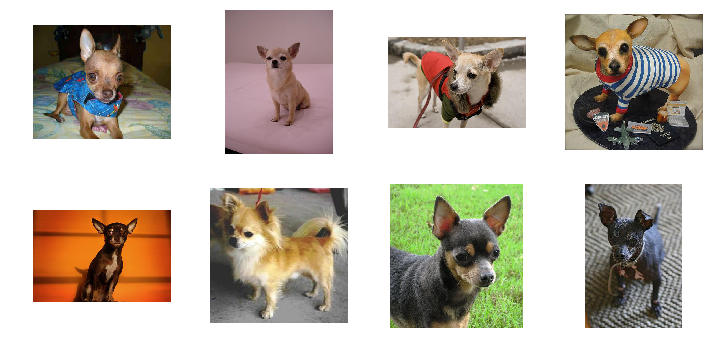

In [10]:
plt.figure(figsize = (10, 5))
for k, i in enumerate(rutaImBase[:8]):
    plt.subplot(2, 4, k + 1)
    imox = plt.imread('./images/' + i[0])
    plt.imshow(imox)
    plt.axis('off')
plt.tight_layout()
plt.show()

### Imagenes de consulta

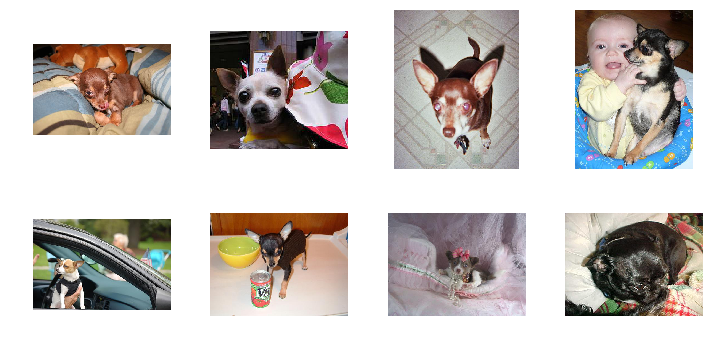

In [11]:
plt.figure(figsize = (10, 5))
for k, i in enumerate(rutaImCon[:8]):
    plt.subplot(2, 4, k + 1)
    imox = plt.imread('./images/' + i[0])
    plt.imshow(imox)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Indice inverso

Vemos en que imagen aparece cada caracterista, es decir tenemos una lista de listas donde la primer lista corresponde a la primer caracteristica y sus elementos son los indices de aquellas imagenes que lo contienen

In [130]:
def Indice(bolsa):
    caract = set([])
    for i in range(len(bolsa)):
        caract = (caract | set(bolsa[i]))
    caract = list(caract)
    ifs = []
    for i in range(len(caract)):
        ifs.append([])
    # i indice de la bolsa, i.e. de imagen de base
    # k elementos del contenido de i
    # l indice de la caracteristica en caract
    for i in range(len(bolsa)):
        for k in bolsa[i]:
            for l in range(len(caract)):
                if k == caract[l]:
                    ifs[l].append(i)
    return ifs, caract

Generamos una función que recibe:

1. Bolsa de características de la imágen de consulta
2. Lista de las características con las que contamos
3. Lista de listas, donde cada lista corresponde a una característica y sus elementos son aquellas imágenes que la contienen
4. Lista de las rutas de las imágenes de base

Esta función compara cada característica de la bolsa con la lista de características y en dado caso que sean iguales, obtenemos su índice, con este índice obtenemos la lista de las imagenes que contienen esta característica, finalmente regresa el índice de las imagenes que contienen características similares y así obtenemos las rutas de estas imágenes.

Esta función va a regresar dos listas, los indices de las imágenes similares, y sus rutas

In [150]:
def Recupera(con, caract, ind, rutIm):
    ind_caract = []
    for i in con:
        if i in caract:
            index = caract.index(i)
            ind_caract.append(index)
    img = []
    for i in ind_caract:
        img.append(ind[i])
    img_final = set([])
    for i, j in enumerate(img):
        for k in j:
            img_final.add(k)
    ind_img = list(img_final)
    result = []
    ind_final = []
    for i in ind_img:
        if i <= len(rutIm):
            result.append(rutIm[i])
            ind_final.append(i)
    return ind_final, result

Generamos nuestras listas del Indice inverso y obtenemos una imagen de consulta

In [133]:
list_list, caract = Indice(bolsaBase)

In [136]:
import random
con = random.randint(0, len(bolsaCon) - 1)
imgCon = bolsaCon[con]

In [151]:
ind_img, result = Recupera(imgCon, caract, list_list, rutaImCon)

## Similitudes
Calculamos la similitud con la imagen de consulta y las imagenes regresadas, las ordenamos por similitud

Por ser distancia de Jaccard y estar basada en conjuntos, si la intersección es nula, $i.e.$ no comparten caracteristicas, entonces obtendremos una distancia de 0, ademas nos interesan aquellas distancias lo mas cercanas a uno, eso querría decir que comparten la mayor cantidad de características posibles.

En general, la distancia nos regresará cero solo cuando las imágenes no compartan características.

In [208]:
def similitud(ds, qs, fd, ind):
    # ds bolsas base
    # qs bolsa consulta
    # funcion de distancia
    # indices de las bolsas
    med = []
    for i, x in enumerate(ds):
        if fd(qs, x) == 0:
            pass
        else:
            res = (fd(qs, x), ind[i])
            med.append(res)
    return med

Como regresamos una lista de tuplas de la distancia entre la imágen de consulta y las imágenes similares; (distancia, imagen), debemos ordenarlas de manera ascendente respecto a su distancia, el primer elemento de cada tupla:

In [219]:
from functools import cmp_to_key
def tuplas(a, b):
    if a[0] > b[0]:
        return 1
    elif a[0] < b[0]:
        return -1
    else:
        if a[1] < b[1]:
            return 1
        elif a[1] > b[1]:
            return -1
        else:
            return 0
        
def ordena(tupla):
    return (tupla[0], -tupla[1])

Obtenemos las rutas de las imágenes mas similares:

In [234]:
def ruta_im_sim(l, rut):
    rutIm = []
    for i in range(len(l)):
        rutIm.append(rut[l[i][1]])
    return rutIm

### Jaccard
$J(C^{(1)},C^{(2)}) = \frac{|C^{(1)} \cap C^{(2)}|}{|C^{(1)} \cup C^{(2)}|} \in [0,1]$

In [149]:
def similitud_Jaccard(x, y):
    set_x = set(x)
    set_y = set(y)
    union_xy = list(set_x | set_y)
    inter_xy = list(set_x & set_y)
    return len(inter_xy)/len(union_xy)

In [209]:
bolsa_result = []
for i in ind_img:
    bolsa_result.append(bolsaCon[i])
jaccard_dist = similitud(bolsa_result, imgCon, similitud_Jaccard, ind_img)

In [245]:
orden = cmp_to_key(tuplas)
j_sim = sorted(jaccard_dist, key = orden)
j_most_sim = j_sim[:8]

Imprimimos la imámen de consulta, recordemos que generamos un número aleatorio llamado $con$ y obtubimos la bolsa de la imágen con ese índice en la bolsa de imágenes de consulta, ent.

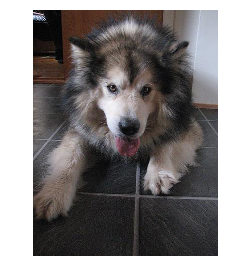

In [241]:
imagenConsulta = rutaImCon[con]
imox = plt.imread('./images/' + imagenConsulta[0])
plt.imshow(imox)
plt.axis('off')
plt.tight_layout()
plt.show()

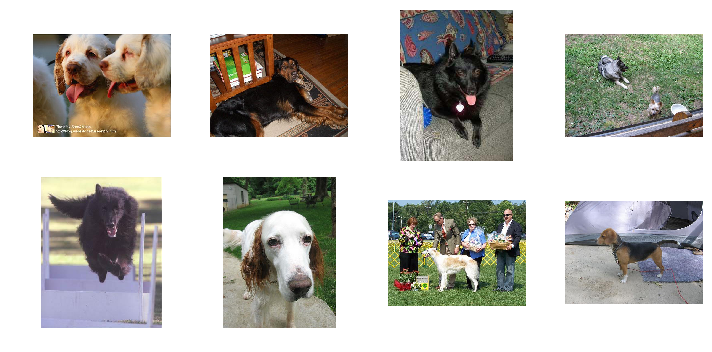

In [246]:
rut_jaccard = ruta_im_sim(j_most_sim, rutaImBase)

plt.figure(figsize = (10, 5))
for k, i in enumerate(rut_jaccard):
    plt.subplot(2, 4, k + 1)
    imox = plt.imread('./images/' + i[0])
    plt.imshow(imox)
    plt.axis('off')
plt.tight_layout()
plt.show()

### MiniMax
$J(\beta^{(1)}, \beta^{(2)}) = \frac{\Sigma_{w=1}^{D} min(\beta_w^{(1)}, \beta_w^{(2)})}{\Sigma_{w=1}^{D} max(\beta_w^{(1)}, \beta_w^{(2)})} \in [0,1]$

donde:
$\beta_w^{(1)}, \beta_w^{(2)}$ son las multiplicidades del elemento $w$ de la bolsa $\beta^{(1)}$ y $\beta^{(2)}$ respectivamente.

In [243]:
def similitud_MiniMax(x, y):
    set_x = set(x)
    set_y = set(y)
    union_xy = list(set_x | set_y)
    inter_xy = list(set_x & set_y)
    minimo = sum(inter_xy)
    maximo = sum(union_xy)
    return minimo/maximo

In [244]:
minmax_dist = similitud(bolsa_result, imgCon, similitud_MiniMax, ind_img)

In [247]:
mm_sim = sorted(minmax_dist, key = orden)
mm_most_sim = mm_sim[:8]

Imágen de consulta

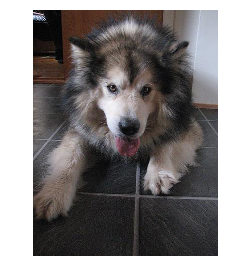

In [248]:
imox = plt.imread('./images/' + imagenConsulta[0])
plt.imshow(imox)
plt.axis('off')
plt.tight_layout()
plt.show()

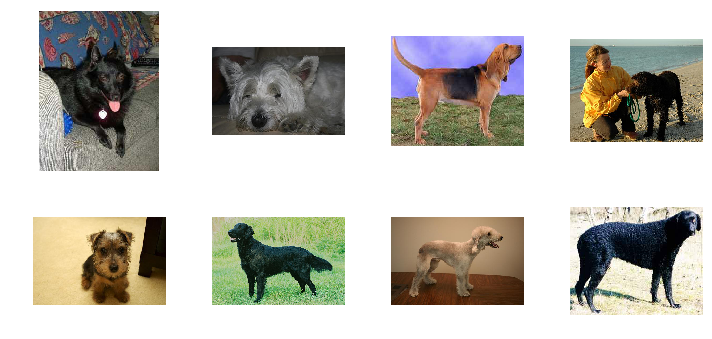

In [249]:
rut_mm = ruta_im_sim(mm_most_sim, rutaImBase)

plt.figure(figsize = (10, 5))
for k, i in enumerate(rut_mm):
    plt.subplot(2, 4, k + 1)
    imox = plt.imread('./images/' + i[0])
    plt.imshow(imox)
    plt.axis('off')
plt.tight_layout()
plt.show()rut_mm = ruta_im_sim(mm_most_sim, rutaImBase)

### Coseno
$cos(\theta)=\frac{x \bullet y}{||x|| \bullet ||y||} = \frac{\Sigma_{i=1}^{L} x_i \bullet y_i}{\sqrt{\Sigma_{i=1}^{L} x_i^2} \bullet \sqrt{\Sigma_{i=1}^{L} y_i^2}}$

In [259]:
import math
def similitud_Coseno(x, y):
    if len(x) > len(y):
        dif = len(x) - len(y)
        for i in range(dif):
            y.append(0)
    if len(x) < len(y):
        dif = len(y) - len(x)
        for i in range(dif):
            x.append(0)
    if len(x) == len(y):
        prod_punto = 0
        x_2 = 0
        y_2 = 0
        for i in range(len(x)):
            prod_punto += x[i]*y[i]
            x_2 += x[i]**2
            y_2 += y[i]**2
        result = prod_punto/((math.sqrt(x_2))*(math.sqrt(y_2)))
        return result

In [260]:
cos_dist = similitud(bolsa_result, imgCon, similitud_Coseno, ind_img)

In [261]:
cos_sim = sorted(cos_dist, key = orden)
cos_most_sim = cos_sim[:8]

Imágen de consulta

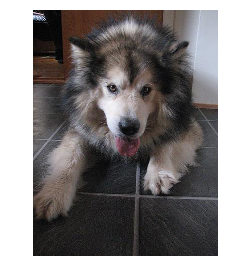

In [254]:
imox = plt.imread('./images/' + imagenConsulta[0])
plt.imshow(imox)
plt.axis('off')
plt.tight_layout()
plt.show()

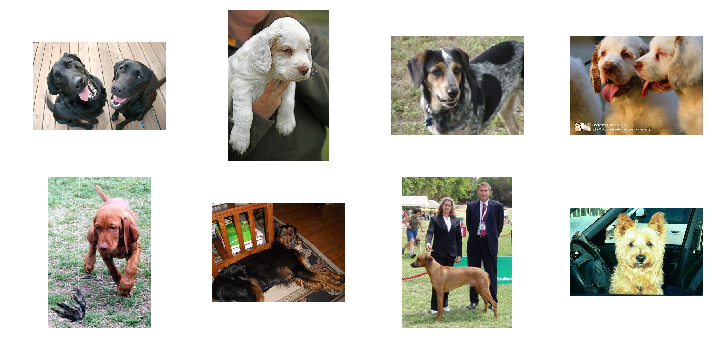

In [255]:
rut_cos = ruta_im_sim(cos_most_sim, rutaImBase)

plt.figure(figsize = (10, 5))
for k, i in enumerate(rut_cos):
    plt.subplot(2, 4, k + 1)
    imox = plt.imread('./images/' + i[0])
    plt.imshow(imox)
    plt.axis('off')
plt.tight_layout()
plt.show()